In [4]:
import pdb
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable, Function
from tqdm import tqdm
from torch.distributions.normal import Normal
from torch.distributions.relaxed_bernoulli import RelaxedBernoulli, LogitRelaxedBernoulli
from torch.distributions.relaxed_categorical import RelaxedOneHotCategorical
from torch.distributions.categorical import Categorical

In [5]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [20]:
# Iris
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
iris = fetch_ucirepo(id=53) 
# data (as pandas dataframes) 
X = iris.data.features 
y = iris.data.targets 

# 处理缺失值
missing_threshold = 0.3
missing_ratio = X.isnull().mean()
X = X.drop(columns=missing_ratio[missing_ratio > missing_threshold].index)  # 删除缺失值比例超过30%的特征

# 处理数据类型转换
y[y.columns[0]] = LabelEncoder().fit_transform(y[y.columns[0]])
for col in X.select_dtypes(include=['object']).columns:
    if X[col].nunique() < 20:  # 类别变量进行编码
        X[col] = LabelEncoder().fit_transform(X[col])
    else:  # 删除冗余字符串特征 (通常为注释)
        X.drop(columns=[col], inplace=True)

# 对剩余缺失值采用中位数填充
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# 归一化特征
scaler_minmax = MinMaxScaler()
scaler_zscore = StandardScaler()

# 对具有高斯分布的特征进行z-score标准化，否则进行min-max归一化
X_scaled = X_imputed.copy()
for col in X_scaled.columns:
    if np.abs(X_scaled[col].skew()) < 1:  # 判断是否接近正态分布
        X_scaled[col] = scaler_zscore.fit_transform(X_scaled[[col]])
    else:
        X_scaled[col] = scaler_minmax.fit_transform(X_scaled[[col]])

# 处理类别不均衡
try:
    smote = SMOTE(sampling_strategy='auto', k_neighbors=1, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
except:
    (X_resampled, y_resampled) = (X_scaled, y)

# 分层拆分数据集（保持类别比例）
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# 查看处理后数据集大小
print(f"训练集大小: {X_train.shape}, 测试集大小: {X_test.shape}")

训练集大小: (120, 4), 测试集大小: (30, 4)


C:\Users\zhangjc\AppData\Local\Temp\ipykernel_1456\2135207758.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y.columns[0]] = LabelEncoder().fit_transform(y[y.columns[0]])


In [10]:
X

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [21]:
y

,class
0,0
1,0
2,0
3,0
4,0
...,...
145,2
146,2
147,2
148,2


In [18]:
X_train

,sepal length,sepal width,petal length,petal width
8,-1.748856,-0.356361,-1.341272,-1.312977
106,-1.143017,-1.281972,0.421564,0.659118
76,1.159173,-0.587764,0.592162,0.264699
9,-1.143017,0.106445,-1.284407,-1.444450
89,-0.416010,-1.281972,0.137236,0.133226
...,...,...,...,...
37,-1.143017,0.106445,-1.284407,-1.444450
2,-1.385353,0.337848,-1.398138,-1.312977
33,-0.416010,2.651878,-1.341272,-1.312977
52,1.280340,0.106445,0.649027,0.396172


In [22]:
y_train

,class
8,0
106,2
76,1
9,0
89,1
...,...
37,0
2,0
33,0
52,1


In [32]:
# 数据集转换为 PyTorch 格式
class CustomDataset():
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 构建 DataLoader
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [33]:
train_loader

In [26]:
def Binarize(tensor,quant_mode='det'):
    if quant_mode=='det':
        tensor = tensor.sign()
        tensor[tensor==0] = 1
        return tensor
    else:
        return tensor.add_(1).div_(2).add_(torch.rand(tensor.size()).add(-0.5)).clamp_(0,1).round().mul_(2).add_(-1)

  
def sampling(mu,sig):
    x = Normal(mu,abs(sig))
    #p = 1 - x.cdf(0)
    p = 1 - x.cdf(torch.tensor(0))
    return p


class PBinarizeLinear(nn.Linear):
    def __init__(self, *kargs, **kwargs):
        super(PBinarizeLinear, self).__init__(*kargs, **kwargs)

    def forward(self, input):      
      
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()  
            
        self.weight.data=Binarize(self.weight.org)
        theta = torch.tanh(self.weight)

        if input.size(1) != 784:
          mu = nn.functional.linear(input,theta)
          left = input**2 - (1- input**2)
          right = theta**2 - (1-theta**2)
          sigma = 1 - nn.functional.linear(left,right)
        else:
          input = torch.tanh(input)
          mu = nn.functional.linear(input,theta)       
          sigma = nn.functional.linear(input**2,1-(theta**2))
        
        m = mu.mean(0,True)
        v = sigma.var(0,True)
     
        mu = 0.5*(mu-m)/((v+(0.0001)).sqrt()+0.5)
        sigma = 0.5**2*sigma/(v+0.0001)

        out1 = sampling(mu,sigma)

        if self.out_features==10:
          return mu
        else:
          return out1



class PBinarizeConv2d(nn.Conv2d):

    def __init__(self, *kargs, **kwargs):
        super(PBinarizeConv2d, self).__init__(*kargs, **kwargs)
        

    def forward(self, input):
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()  
            
        self.weight.data=Binarize(self.weight.org)
        theta = torch.tanh(self.weight)
        
        if input.size(1) != 1:
          mu = nn.functional.conv2d(input, theta, None, self.stride,
                                   self.padding, self.dilation, self.groups)
          left = input**2 - (1- input**2)
          right = theta**2 - (1-theta**2)
          sigma = 1 - nn.functional.conv2d(left, right, None, self.stride,
                                   self.padding, self.dilation, self.groups)
        else:
          input = torch.tanh(input)
          mu = nn.functional.conv2d(input, theta, None, self.stride,
                                   self.padding, self.dilation, self.groups)
          sigma = nn.functional.conv2d(input**2, 1-(theta**2), None, self.stride,
                                   self.padding, self.dilation, self.groups)

        m = mu.mean((0,2,3),True)
        v = sigma.var((0,2,3)).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
     
        mu = 0.5*(mu-m)/((v+(0.0001)).sqrt()+0.5)
        sigma = 0.5**2*sigma/(v+0.0001)
     
        mu = nn.functional.max_pool2d(mu, 2, 2,0, 1, False,False)
        sigma = nn.functional.max_pool2d(sigma, 2, 2,0, 1, False,False)
                            
        
        out1 = sampling(mu,sigma)
   
        return out1

In [28]:
# 构建概率二值 MLP 网络
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = PBinarizeLinear(input_dim, 512)
        self.fc2 = PBinarizeLinear(512, 256)
        self.fc3 = PBinarizeLinear(256, 128)
        self.fc4 = PBinarizeLinear(128, output_dim)  # 依据类别数调整输出维度

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x
  
# 初始化模型，确保输出层维度匹配类别数
input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))  # 获取 y_train 中唯一类别的数量


model = MLP(input_dim, output_dim)
print(model)
torch.cuda.device('cuda')
model.cuda()

MLP(
  (fc1): PBinarizeLinear(in_features=4, out_features=512, bias=True)
  (fc2): PBinarizeLinear(in_features=512, out_features=256, bias=True)
  (fc3): PBinarizeLinear(in_features=256, out_features=128, bias=True)
  (fc4): PBinarizeLinear(in_features=128, out_features=3, bias=True)
)


MLP(
  (fc1): PBinarizeLinear(in_features=4, out_features=512, bias=True)
  (fc2): PBinarizeLinear(in_features=512, out_features=256, bias=True)
  (fc3): PBinarizeLinear(in_features=256, out_features=128, bias=True)
  (fc4): PBinarizeLinear(in_features=128, out_features=3, bias=True)
)

In [29]:
def train(epoch):
    model.train()
    losses = []
    trainloader = tqdm(train_loader)
    
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

#         if epoch%40==0:
#             optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']*0.1

        loss.backward()
    
        for p in list(model.parameters()):
            if hasattr(p,'org'):
                p.data.copy_(p.org)
        optimizer.step()
        
        for p in list(model.parameters()):
            if hasattr(p,'org'):
                p.org.copy_(p.data.clamp_(-0.9,0.9))
    
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)



def test():
    model.eval()
    test_loss = 0
    correct = 0
    testloader = tqdm(test_loader)
    for data, target in testloader:
        data, target = data.cuda(), target.cuda()
        with torch.no_grad():
          data = Variable(data)
        target = Variable(target)
        output = model(data)
        test_loss += criterion(output, target).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        loss = test_loss / len(test_loader.dataset)
        acc = (100. *correct / len(test_loader.dataset)).numpy()

        testloader.set_postfix(loss= loss,acc=str(acc)+'%')
    
    test_loss /= len(test_loader.dataset)
    total_acc = correct.item()/len(test_loader.dataset)
    loss_history.append(test_loss)
    acc_history.append(total_acc)

In [30]:
%%time
loss_history = []
acc_history = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


for epoch in range(20):
    train(epoch)
    test()

  0%|                                                | 0/1 [00:07<?, ?it/s]


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

[0.0010781190890818834, 0.0007760681830346585, 0.0006693357141688466, 0.0005971903020516038, 0.0006840071419253945, 0.0005628254530020058, 0.0005865011770278216, 0.0005056997385807335, 0.00046249814676120875, 0.0005050163511186838, 0.0004469675570726395, 0.0004904286528006196, 0.0004683349028229713, 0.0005216651184484362, 0.0004924797281622887, 0.00046422207781579344, 0.0004356077604461461, 0.00047684772275388243, 0.0004553934431634843, 0.0004483071647584438]
[0.9585, 0.9722, 0.9729, 0.9759, 0.9727, 0.9777, 0.9781, 0.9791, 0.9815, 0.979, 0.9819, 0.9806, 0.9815, 0.9794, 0.9813, 0.9821, 0.9822, 0.9801, 0.9804, 0.9818]


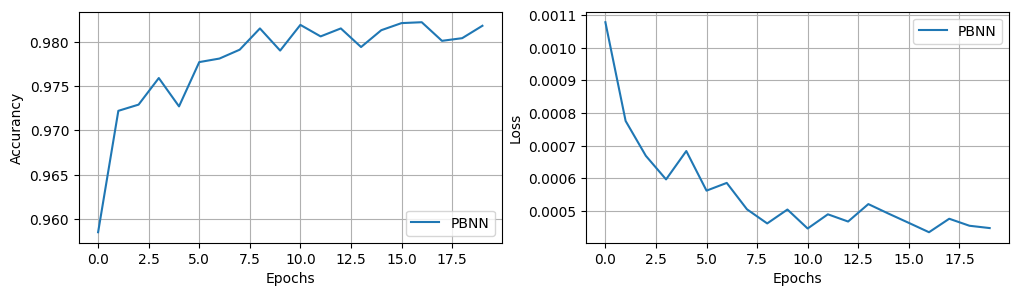

In [9]:
#1
def visualization():
    print(loss_history)
    print(acc_history)
    
    f = plt.figure(figsize=(12,3))
    ax = f.add_subplot(121)
    ax.plot(acc_history,label='PBNN')
    ax.grid()
    ax.set_ylabel('Accurancy')
    ax.set_xlabel('Epochs')
    ax.legend(loc='lower right')
    
    ax2 = f.add_subplot(122)
    ax2.plot(loss_history,label='PBNN')
    ax2.grid()
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epochs')
    ax2.legend(loc='upper right')

visualization()

100%|███████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.43it/s, acc=97.98%, loss=0.000486]


[0.0005348965407349169, 0.0005614008092321456, 0.00040889732842333613, 0.0005403519027866423, 0.00045535391429439185, 0.0004989083657041192, 0.0004535781775135547, 0.0004960357327014208, 0.0005371909208595752, 0.0004620288331992924, 0.0004883234239183367, 0.0005083820980973542, 0.0005847464955411852, 0.0004680342817679048, 0.000648760789912194, 0.0004978462911210955, 0.0004335200134897605, 0.0004941140444017947, 0.0005973855402320623, 0.00048598693609237673]
[0.9792, 0.9799, 0.9838, 0.9766, 0.9814, 0.9808, 0.9822, 0.9794, 0.9799, 0.9814, 0.9806, 0.9787, 0.9748, 0.9816, 0.9742, 0.9795, 0.9818, 0.9823, 0.9764, 0.9798]
CPU times: total: 18min 18s
Wall time: 19min 42s


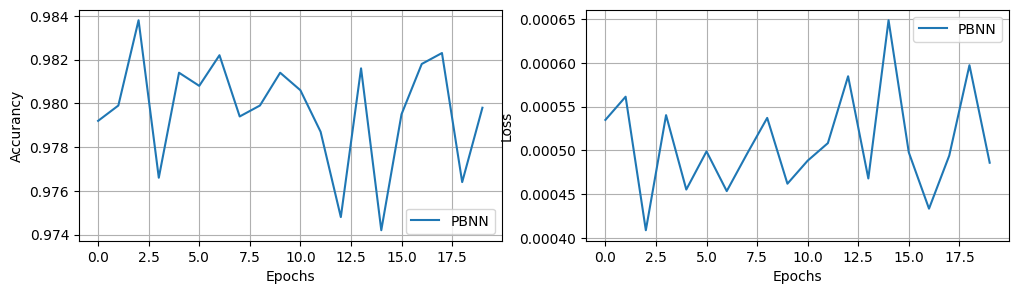

In [11]:
%%time
# 高斯噪声 sigma = 0.1
class AddGaussianNoise(torch.nn.Module):
    def __init__(self, mean=0., std=0.1):
        super().__init__()
        self.mean = mean
        self.std = std

    def forward(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std

gaussian_noise = AddGaussianNoise(std=0.1)  # 控制σ∈[0, 0.5]
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       gaussian_noise  # 添加高斯噪声
                   ])),
    batch_size=128, shuffle=True)

# 训练
loss_history = []
acc_history = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(20):
    train(epoch)
    test()

# 可视化
visualization()

100%|███████████████████████████████████████████████████████| 79/79 [00:06<00:00, 13.11it/s, acc=97.85%, loss=0.000549]


[0.0007635679775848985, 0.000580389585904777, 0.000730949098803103, 0.0005833845645189285, 0.0007147533731535077, 0.0006418612568639219, 0.0005778599619865418, 0.0005996113806962966, 0.0008537985723465682, 0.0005576830417849123, 0.0006215618858113885, 0.0005759166351228486, 0.0007081769097596407, 0.0006134784625843168, 0.0007571334093809127, 0.0006755769177339971, 0.0005535509063862264, 0.0005475291402079165, 0.0006328251840546727, 0.0005488511566072703]
[0.9705, 0.9773, 0.9731, 0.9746, 0.9699, 0.9766, 0.9747, 0.9763, 0.9688, 0.9782, 0.9766, 0.9764, 0.9725, 0.9745, 0.9717, 0.9725, 0.9776, 0.9776, 0.9758, 0.9785]
CPU times: total: 18min 29s
Wall time: 19min 49s


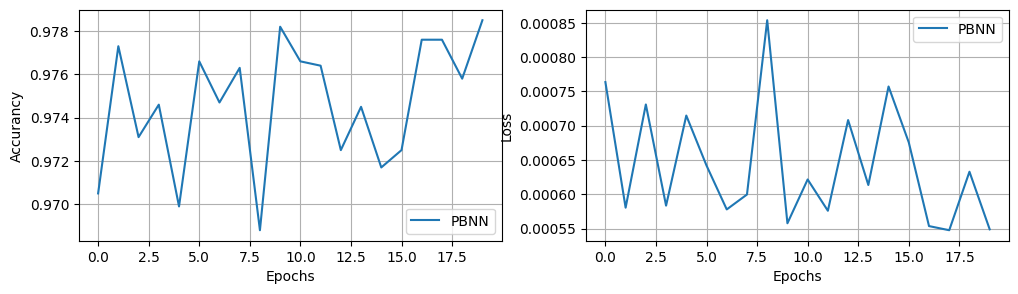

In [12]:
%%time
# 高斯噪声 sigma = 0.5
gaussian_noise = AddGaussianNoise(std=0.5)  # 控制σ∈[0, 0.5]
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       gaussian_noise  # 添加高斯噪声
                   ])),
    batch_size=128, shuffle=True)

# 训练
loss_history = []
acc_history = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
for epoch in range(20):
    train(epoch)
    test()

# 可视化
visualization()

100%|████████████████████████████████████████████████████████| 79/79 [00:06<00:00, 12.71it/s, acc=98.23%, loss=0.00048]


[0.0004459167181048542, 0.00044598437887616456, 0.0005079422917217016, 0.0005025553545914591, 0.00046187490429729224, 0.00054416155773215, 0.0004948086035437882, 0.00047254707580432297, 0.0005068230459466576, 0.0004779275888577104, 0.00041451661391183735, 0.00045929036336019637, 0.00046821974092163147, 0.0005548089292831718, 0.0004883190430235118, 0.0004910575492307543, 0.0004941187624819577, 0.0004446530390065163, 0.00045432216320186853, 0.00048042481369338927]
[0.9806, 0.9819, 0.9805, 0.9791, 0.983, 0.9793, 0.979, 0.981, 0.9799, 0.9803, 0.9835, 0.9819, 0.9807, 0.9797, 0.9804, 0.9794, 0.9811, 0.9827, 0.9811, 0.9823]
CPU times: total: 16min 21s
Wall time: 17min 26s


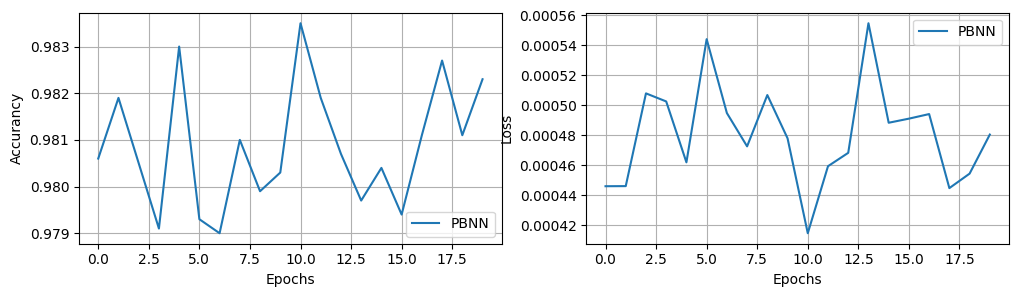

In [13]:
%%time
# 训练标签噪声，noise_level = 0.1
def add_label_noise(labels, noise_level=0.1):  # p∈[0, 40%]
    num_noisy = int(noise_level * len(labels))
    indices = torch.randperm(len(labels))[:num_noisy]
    noisy_labels = labels.clone()
    noisy_labels[indices] = torch.randint(0, 10, (num_noisy,))
    return noisy_labels

# 加载数据
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=128, shuffle=True)
# 翻转部分标签
for batch_idx, (data, target) in enumerate(train_loader):
    target = add_label_noise(target, noise_level=0.1)
# 训练
loss_history = []
acc_history = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
for epoch in range(20):
    train(epoch)
    test()
# 可视化
visualization()

100%|███████████████████████████████████████████████████████| 79/79 [00:05<00:00, 13.21it/s, acc=98.27%, loss=0.000431]


[0.00048220768920145926, 0.0004146386114880443, 0.0004658888835925609, 0.0004761032445821911, 0.00042945048841647805, 0.0005506656584329903, 0.0004697950296686031, 0.0004456417860928923, 0.00045742327207699417, 0.0004642297981772572, 0.0004766150730662048, 0.0004377649477683008, 0.00042173847067169845, 0.00044153102192794904, 0.00043905482199043034, 0.0004732350525911897, 0.0004861561473459005, 0.0004963496603537351, 0.00045754237212240696, 0.00043055723422439767]
[0.9801, 0.9839, 0.9812, 0.9819, 0.9821, 0.9801, 0.9794, 0.983, 0.984, 0.982, 0.9811, 0.9828, 0.9828, 0.9819, 0.9827, 0.9817, 0.9821, 0.9806, 0.981, 0.9827]
CPU times: total: 16min 16s
Wall time: 17min 20s


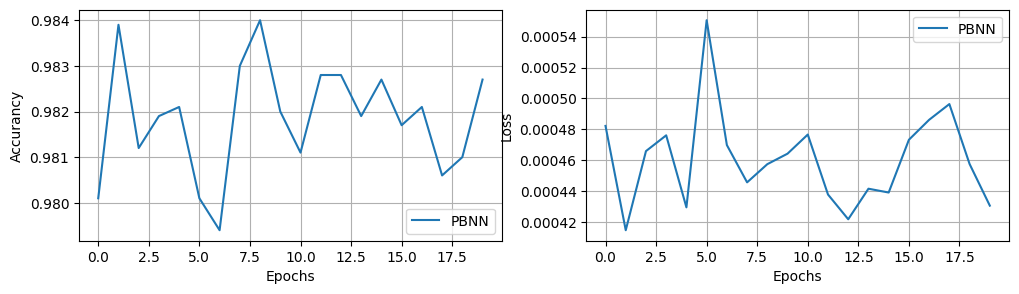

In [14]:
%%time
# 训练标签噪声，noise_level = 0.4
# 加载数据
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=128, shuffle=True)
# 翻转部分标签
for batch_idx, (data, target) in enumerate(train_loader):
    target = add_label_noise(target, noise_level=0.4)
# 训练
loss_history = []
acc_history = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
for epoch in range(20):
    train(epoch)
    test()
# 可视化
visualization()

100%|███████████████████████████████████████████████████████| 79/79 [00:05<00:00, 14.47it/s, acc=98.29%, loss=0.000447]


[0.0004835592458024621, 0.00048434245688840744, 0.0004758656932041049, 0.00048612582432106135, 0.00047753335065208374, 0.0004276166754774749, 0.00046225203778594735, 0.0004403214156627655, 0.0005010717513039708, 0.0004438630724325776, 0.0005113579886266962, 0.0004568872911040671, 0.0005170909864827991, 0.0004706101693212986, 0.00043988050259649754, 0.0004181424158159643, 0.00047509852428920566, 0.0005157484392635524, 0.0004390088246203959, 0.0004465521945618093]
[0.9792, 0.9799, 0.9821, 0.9821, 0.9798, 0.9822, 0.9816, 0.9829, 0.9806, 0.9827, 0.9792, 0.9807, 0.9794, 0.9806, 0.9835, 0.9831, 0.981, 0.9804, 0.9831, 0.9829]


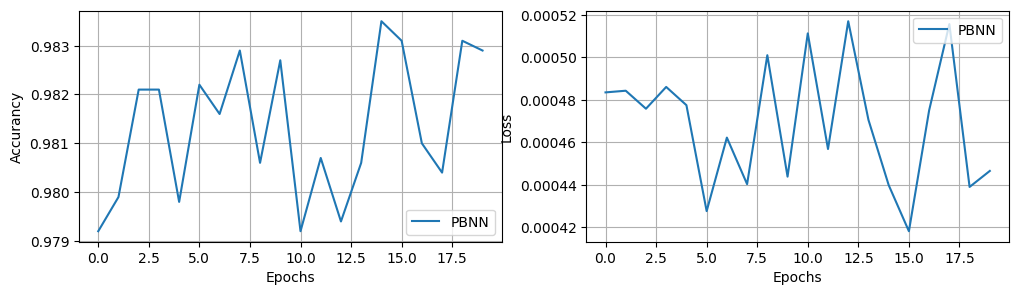

In [15]:
# 激活函数噪声 (q=0.1)
def apply_activation_noise(tensor, q=0.3):  # q∈[0, 0.3]
    noise_mask = torch.bernoulli(torch.full_like(tensor, q))
    return tensor * noise_mask

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = PBinarizeConv2d(1, 32, kernel_size=3)
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = PBinarizeConv2d(32, 64, kernel_size=3)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = PBinarizeLinear(1600, 512)
        self.fc2 = PBinarizeLinear(512, 10)
    def forward(self, x):
        x = apply_activation_noise(self.conv1(x), q=0.1)  # 在卷积层施加噪声
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = apply_activation_noise(self.fc1(x), q=0.1)  # 在全连接层施加噪声
        x = self.fc2(x)
        return x

# 加载数据
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=128, shuffle=True)
# 训练
loss_history = []
acc_history = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
for epoch in range(20):
    train(epoch)
    test()
# 可视化
visualization()

100%|███████████████████████████████████████████████████████| 79/79 [00:06<00:00, 12.16it/s, acc=98.27%, loss=0.000444]


[0.00041935854507610203, 0.0004710974116809666, 0.0004191104638390243, 0.0004398790819104761, 0.0005405188085511327, 0.00047090582558885214, 0.00046804210096597674, 0.0005942479176446795, 0.0004069941569119692, 0.00045640010996721685, 0.00045085172094404697, 0.0004924839962739498, 0.00045889979908242824, 0.0003669945715460926, 0.0004540489527862519, 0.00045051164268516004, 0.00045136807216331363, 0.0003923195633571595, 0.00041303001833148303, 0.00044428069787099956]
[0.9816, 0.9818, 0.983, 0.98, 0.9794, 0.9816, 0.9828, 0.977, 0.9835, 0.9824, 0.9814, 0.9797, 0.9824, 0.9851, 0.9798, 0.9814, 0.9828, 0.9854, 0.9828, 0.9827]


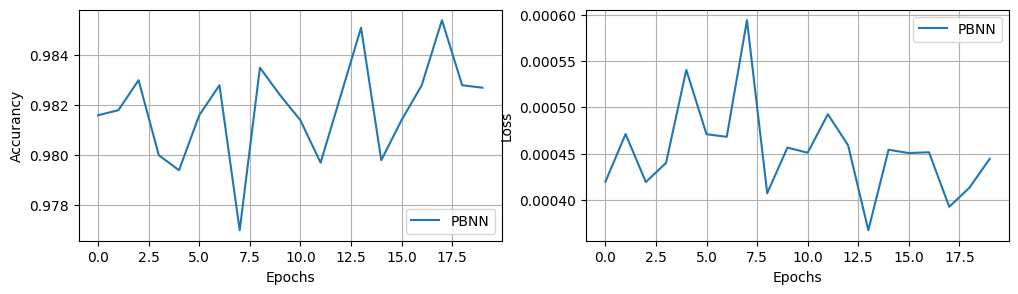

In [16]:
# 激活函数噪声 (q=0.3)
def apply_activation_noise(tensor, q=0.3):  # q∈[0, 0.3]
    noise_mask = torch.bernoulli(torch.full_like(tensor, q))
    return tensor * noise_mask

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = PBinarizeConv2d(1, 32, kernel_size=3)
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = PBinarizeConv2d(32, 64, kernel_size=3)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = PBinarizeLinear(1600, 512)
        self.fc2 = PBinarizeLinear(512, 10)
    def forward(self, x):
        x = apply_activation_noise(self.conv1(x), q=0.3)  # 在卷积层施加噪声
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = apply_activation_noise(self.fc1(x), q=0.3)  # 在全连接层施加噪声
        x = self.fc2(x)
        return x

# 训练
loss_history = []
acc_history = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
for epoch in range(20):
    train(epoch)
    test()
# 可视化
visualization()